In [1]:
# ## install finrl library
# !pip install wrds
# !pip install quantstats
# !pip install torch_geometric
# !pip install swig
# !pip install -q condacolab
# !pip install shimmy
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/flpymonkey/FinRL-Fork.git

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline

# from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [5]:
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2020-12-31'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-01-01'

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import DOW_30_TICKER


# TODO Drop the DOW stock
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
print(DOW_30_TICKER)

# No time window needed for PPO
# TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

raw_df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (107677, 8)


In [6]:
print(raw_df)

              date        open        high         low       close     volume  \
0       2009-04-01    3.717500    3.892857    3.710357    3.274469  589372000   
1       2009-04-01   48.779999   48.930000   47.099998   34.259613   10850100   
2       2009-04-01   13.340000   14.640000   13.080000   11.463931   27701800   
3       2009-04-01   34.520000   35.599998   34.209999   26.850754    9288800   
4       2009-04-01   27.500000   29.520000   27.440001   19.116173   15308300   
...            ...         ...         ...         ...         ...        ...   
107672  2023-12-29  525.979980  528.239990  523.919983  520.342346    2080100   
107673  2023-12-29  260.570007  261.459991  259.670013  258.375092    4074600   
107674  2023-12-29   37.380001   37.759998   37.320000   35.344772   16205200   
107675  2023-12-29   26.440001   26.629999   25.750000   24.868887   10853300   
107676  2023-12-29   52.509998   52.693333   52.386665   52.042637   21948300   

         tic  day  
0      

In [7]:
# join the Betas

beta_monthly = pd.read_csv('./beta_outputs.csv')

raw_df['join_date'] = pd.to_datetime(raw_df['date'])
beta_monthly['join_date'] = pd.to_datetime(beta_monthly['date'])


In [8]:

# Create new columns for month and year
raw_df['month'] = raw_df['join_date'].dt.month
raw_df['year'] = raw_df['join_date'].dt.year

beta_monthly['month'] = beta_monthly['join_date'].dt.month
beta_monthly['year'] = beta_monthly['join_date'].dt.year
beta_monthly.rename(columns={'ticker': 'tic'}, inplace=True)

# join the betas
processed = pd.merge(raw_df, beta_monthly, on=['tic', 'month', 'year'])

processed = processed[['date_x', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day', 'beta']]

processed.rename(columns={'date_x': 'date'}, inplace=True)

print(processed)

              date        open        high         low       close     volume  \
0       2009-04-01    3.717500    3.892857    3.710357    3.274469  589372000   
1       2009-04-01   48.779999   48.930000   47.099998   34.259613   10850100   
2       2009-04-01   13.340000   14.640000   13.080000   11.463931   27701800   
3       2009-04-01   34.520000   35.599998   34.209999   26.850754    9288800   
4       2009-04-01   27.500000   29.520000   27.440001   19.116173   15308300   
...            ...         ...         ...         ...         ...        ...   
107672  2023-12-29  525.979980  528.239990  523.919983  520.342346    2080100   
107673  2023-12-29  260.570007  261.459991  259.670013  258.375092    4074600   
107674  2023-12-29   37.380001   37.759998   37.320000   35.344772   16205200   
107675  2023-12-29   26.440001   26.629999   25.750000   24.868887   10853300   
107676  2023-12-29   52.509998   52.693333   52.386665   52.042637   21948300   

         tic  day      beta

In [9]:
max_close_by_tic = processed.groupby('tic')['beta'].max()

print(max_close_by_tic)

tic
AAPL    1.655085
AMGN    1.144200
AXP     2.298922
BA      1.915849
CAT     2.158136
CRM     1.961910
CSCO    1.472151
CVX     1.349292
DIS     1.452860
GS      1.784304
HD      1.178428
HON     1.508984
IBM     1.271182
INTC    1.240405
JNJ     0.800009
JPM     1.785136
KO      0.758778
MCD     0.837352
MMM     1.292105
MRK     0.978721
MSFT    1.136891
NKE     1.164661
PG      0.695245
TRV     1.270427
UNH     1.112268
V       1.034512
VZ      0.740431
WBA     1.473561
WMT     0.598832
Name: beta, dtype: float64


In [10]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler


# TODO - we are using the normalized indicators here, is that okay?


portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed)
portfolio_norm_df

,date,open,high,low,close,volume,tic,day,beta
0,2009-04-01,0.018773,0.019501,0.018834,0.016610,0.313329,AAPL,0.5,1.000000
1,2009-04-01,0.165873,0.164931,0.162829,0.121385,0.216841,AMGN,0.5,0.452897
2,2009-04-01,0.067544,0.073365,0.066315,0.059964,0.306650,AXP,0.5,0.945263
3,2009-04-01,0.077397,0.079819,0.077716,0.062400,0.089997,BA,0.5,0.724638
4,2009-04-01,0.092561,0.098663,0.092690,0.065151,0.243804,CAT,0.5,0.880761
...,...,...,...,...,...,...,...,...,...
107672,2023-12-29,0.947712,0.946497,0.952357,0.955325,0.059607,UNH,1.0,0.562258
107673,2023-12-29,0.990045,0.993200,1.000000,0.992263,0.012072,V,1.0,0.976533
107674,2023-12-29,0.602806,0.606879,0.608313,0.722690,0.026281,VZ,1.0,0.554449
107675,2023-12-29,0.272493,0.273690,0.267421,0.363286,0.129006,WBA,1.0,0.600807


In [11]:
portfolio_norm_df.groupby("tic").count()

,date,open,high,low,close,volume,day,beta
tic,,,,,,,,
AAPL,3713,3713,3713,3713,3713,3713,3713,3713
AMGN,3713,3713,3713,3713,3713,3713,3713,3713
AXP,3713,3713,3713,3713,3713,3713,3713,3713
BA,3713,3713,3713,3713,3713,3713,3713,3713
CAT,3713,3713,3713,3713,3713,3713,3713,3713
CRM,3713,3713,3713,3713,3713,3713,3713,3713
CSCO,3713,3713,3713,3713,3713,3713,3713,3713
CVX,3713,3713,3713,3713,3713,3713,3713,3713
DIS,3713,3713,3713,3713,3713,3713,3713,3713


In [12]:
stock_dimension = len(portfolio_norm_df.tic.unique())
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 29


In [13]:
df_train = portfolio_norm_df[(portfolio_norm_df["date"] >= TRAIN_START_DATE) & (portfolio_norm_df["date"] <= TRAIN_END_DATE)]
df_2021 = portfolio_norm_df[(portfolio_norm_df["date"] >= TEST_START_DATE) & (portfolio_norm_df["date"] <= "2021-12-31")]
df_2022 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2022-01-01") & (portfolio_norm_df["date"] <= "2022-12-31")]
df_2023 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2023-01-01") & (portfolio_norm_df["date"] < TEST_END_DATE)]

# TODO use the start and end date here

df_train.groupby("tic").count()

,date,open,high,low,close,volume,day,beta
tic,,,,,,,,
AAPL,2960,2960,2960,2960,2960,2960,2960,2960
AMGN,2960,2960,2960,2960,2960,2960,2960,2960
AXP,2960,2960,2960,2960,2960,2960,2960,2960
BA,2960,2960,2960,2960,2960,2960,2960,2960
CAT,2960,2960,2960,2960,2960,2960,2960,2960
CRM,2960,2960,2960,2960,2960,2960,2960,2960
CSCO,2960,2960,2960,2960,2960,2960,2960,2960
CVX,2960,2960,2960,2960,2960,2960,2960,2960
DIS,2960,2960,2960,2960,2960,2960,2960,2960


# TODO can I used ANOVA, or Analysis of Variance,

Compare with ANova,
Returns 
Drawdown period
And sharpe ratio

In [14]:
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [15]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv

from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent



from stable_baselines3.common.logger import configure
# Try also training a PPO agent on this same environment


environment = PortfolioOptimizationEnv(
        df_train,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low", 'beta'], # USE THE BETA INDICATOR
        normalize_df=None,
        reward_scaling=1e-4,
    )


# TODO figuring out issues with timesteps: https://stackoverflow.com/questions/56700948/understanding-the-total-timesteps-parameter-in-stable-baselines-models

agent_ppo = DRLStableAgent(env = environment)
PPO_PARAMS = {
    "n_steps": 50,
    # "ent_coef": 0.2,
    "learning_rate": 0.00025, # TODO tried raising the lr which caused vanishing problem
    # "clip_range": 0.2
}

# Lower clip_range makes the stocks flatter, very conservative policy

# TODO try playing around with the number of epochs? n_epochs
# TODO try playing around more with the entropy term, make sure agent does enough exploration during training
# TODO try playing around more with the clip papram here


model_ppo = agent_ppo.get_model("ppo", device, model_kwargs=PPO_PARAMS, policy_kwargs=None)

# set up logger
tmp_path = RESULTS_DIR + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

Logging to results/ppo


In [16]:
# Once optimal policy is learned it shouldnt be stochastic, giventhe state

# TODO see graphs below, need to have the correct number of timestemps and add epochs
model_ppo = DRLStableAgent.train_model(model_ppo, env=environment, episodes=1)

from finrl.config import TRAINED_MODEL_DIR

model_ppo.save(TRAINED_MODEL_DIR + "/agent_opt_ppo_betas")

Max number of time steps in an episode:  2960
-----------------------------
| time/              |      |
|    fps             | 21   |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 50   |
| train/             |      |
|    reward          | None |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 100         |
| train/                  |             |
|    approx_kl            | 0.041964587 |
|    clip_fraction        | 0.316       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.6       |
|    explained_variance   | -0.534      |
|    learning_rate        | 0.00025     |
|    loss                 | -0.112      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0754     |
|    reward 

=================================

Initial portfolio value:1000000

Final portfolio value: 2095667.0

Final accumulative portfolio value: 2.095667

Maximum DrawDown: -0.3176763620505515

Sharpe ratio: 0.45804334145915476

=================================

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.96e+03    |
|    ep_rew_mean          | 7.5e-05     |
| time/                   |             |
|    fps                  | 29          |
|    iterations           | 60          |
|    time_elapsed         | 101         |
|    total_timesteps      | 3000        |
| train/                  |             |
|    approx_kl            | 0.048642263 |
|    clip_fraction        | 0.252       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.6       |
|    explained_variance   | 0.225       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.0945     |
|    n_updates            | 590         |
|    policy_gradient_loss | -0.0543     |
|    reward               | None        |
|    std                  | 1           |
|    value_loss           | 0.000317    |
-----------------------------------------


In [17]:
print(len(df_2021.index.unique()) - 1)
print(df_2021)

7307
             date      open      high       low     close    volume   tic  \
85840  2021-01-04  0.674275  0.669322  0.643452  0.641887  0.076184  AAPL   
85841  2021-01-04  0.786351  0.779486  0.773249  0.714092  0.061718  AMGN   
85842  2021-01-04  0.614177  0.610373  0.592425  0.586691  0.038435   AXP   
85843  2021-01-04  0.470841  0.471290  0.460006  0.471113  0.205649    BA   
85844  2021-01-04  0.615954  0.621591  0.608870  0.573017  0.064952   CAT   
...           ...       ...       ...       ...       ...       ...   ...   
93143  2021-12-31  0.908360  0.908206  0.912584  0.886311  0.048583   UNH   
93144  2021-12-31  0.823777  0.828034  0.829861  0.813280  0.013994     V   
93145  2021-12-31  0.841800  0.840726  0.845640  0.879738  0.025804    VZ   
93146  2021-12-31  0.534886  0.538746  0.538270  0.647096  0.040493   WBA   
93147  2021-12-31  0.850457  0.853478  0.853203  0.829496  0.073952   WMT   

       day      beta  
85840  0.0  0.663871  
85841  0.0  0.598241  
8

In [18]:
PPO_results = {
    "date": environment._terminal_date_memory,
    "training": environment._terminal_asset_memory["final"],
    "2021": {},
    "2022": {},
    "2023": {}
}


environment_2021 = PortfolioOptimizationEnv(
    df_2021,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low",'beta'],
    normalize_df=None,
        reward_scaling=1e-4,
)


environment_2022 = PortfolioOptimizationEnv(
    df_2022,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low",'beta'],
    normalize_df=None,
        reward_scaling=1e-4,
)

environment_2023 = PortfolioOptimizationEnv(
    df_2023,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low",'beta'],
    normalize_df=None,
        reward_scaling=1e-4,
)


print(model_ppo._num_timesteps_at_start)

# 2021
values, dates = DRLStableAgent.DRL_prediction(model_ppo, environment_2021)
PPO_results["2021"]["value"] = environment_2021._terminal_asset_memory["final"]
PPO_results["2021"]["date"] = environment_2021._terminal_date_memory


# 2022
values, dates = DRLStableAgent.DRL_prediction(model_ppo, environment_2022)
PPO_results["2022"]["value"] = environment_2022._terminal_asset_memory["final"]
PPO_results["2022"]["date"] = environment_2022._terminal_date_memory

# # 2023
# DRLStableAgent.DRL_prediction(model_ppo, environment_2023)
# PPO_results["2023"]["value"] = environment_2023._asset_memory["final"]
# PPO_results["2023"]["date"] = environment_2023._date_memory

0
Initial portfolio value:1000000
Final portfolio value: 1230352.0
Final accumulative portfolio value: 1.230352
Maximum DrawDown: -0.0629304600343753
Sharpe ratio: 1.8361411006436548
hit end!
Initial portfolio value:1000000
Final portfolio value: 920839.0625
Final accumulative portfolio value: 0.9208390625
Maximum DrawDown: -0.21022320531366379
Sharpe ratio: -0.32594252810866686
hit end!


In [19]:
print(len(df_2021['date'].unique()) - 1)

print(len(PPO_results['date']))

251
2960


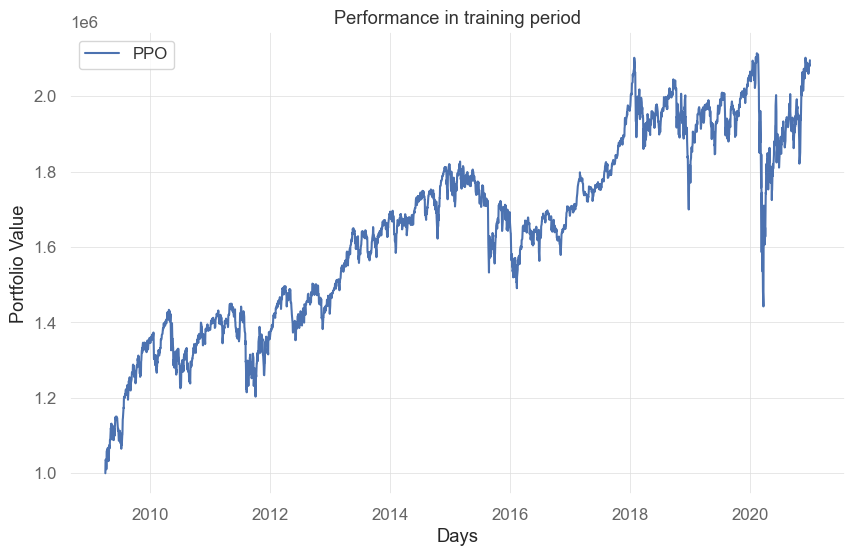

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(PPO_results["date"], PPO_results["training"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

In [ ]:
UBAH_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {},
}

PORTFOLIO_SIZE = len(DOW_30_TICKER)



# This is the CRP strategy NOT Buy and hold 
# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._terminal_asset_memory["final"]
UBAH_results["train"]["date"] = environment._terminal_date_memory

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._terminal_asset_memory["final"]
UBAH_results["2021"]["date"] = environment_2021._terminal_date_memory

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._terminal_asset_memory["final"]
UBAH_results["2022"]["date"] = environment_2022._terminal_date_memory

# # 2023
# terminated = False
# environment_2023.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2023.step(action)
# UBAH_results["2023"]["value"] = environment_2023._terminal_asset_memory["final"]
# UBAH_results["2023"]["date"] = environment_2023._terminal_date_memory

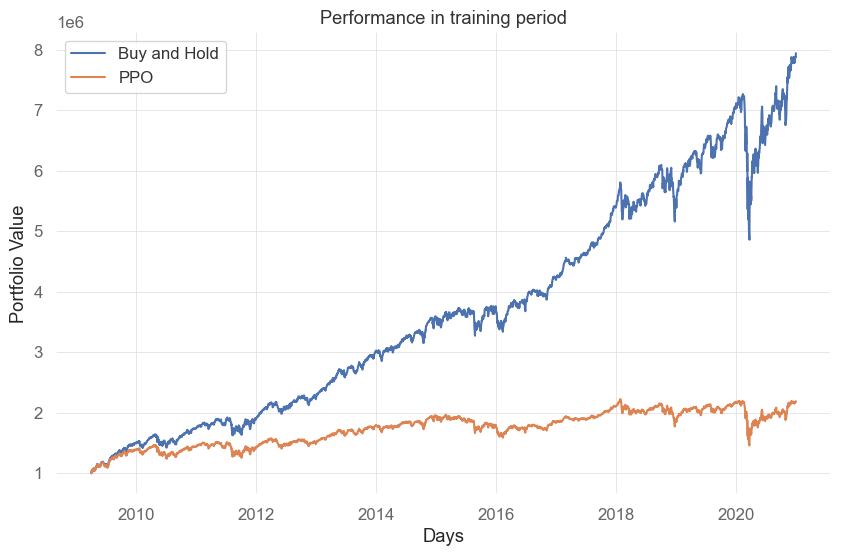

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["date"], UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(PPO_results["date"], PPO_results["training"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

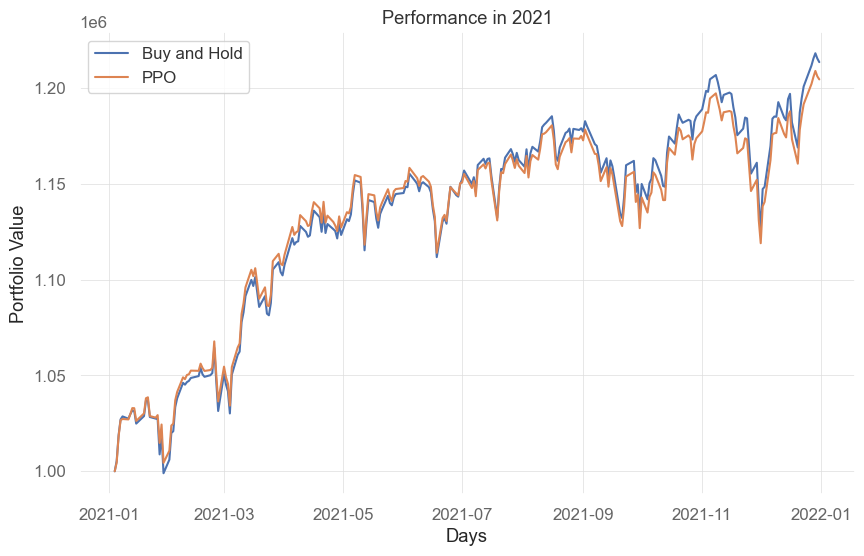

In [ ]:
plt.plot(UBAH_results["2021"]["date"], UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(PPO_results["2021"]["date"], PPO_results["2021"]["value"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

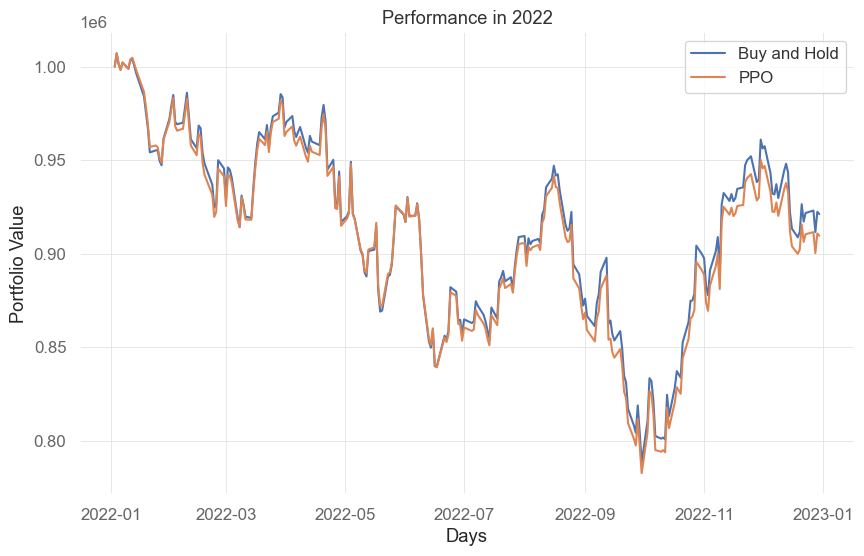

In [ ]:
plt.plot(UBAH_results["2022"]["date"], UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(PPO_results["2022"]["date"], PPO_results["2022"]["value"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

In [ ]:
# plt.plot(UBAH_results["2023"]["date"], UBAH_results["2023"]["value"], label="Buy and Hold")
# plt.plot(PPO_results["2023"]["date"], PPO_results["2023"]["value"], label="PPO")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in 2023")
# plt.legend()

# plt.show()

In [ ]:
# import shutil
# shutil.make_archive('train', 'zip', '../content')

# from google.colab import files
# files.download("train.zip")